# Vanilla GAN for generating MNIST digits using torch7

GANs were introduced by Goodfellow et al. in <a href="https://arxiv.org/pdf/1406.2661.pdf">this</a> famous paper. The idea, in a nutshell, is to make two networks - the generator and discriminator compete with other in a minimax game. The generator tries to fool the discriminator creating more and more realistic images, and the discriminator tries not to be fooled by the generator.

There seem to be a bunch of GAN implementations around in TensorFlow, Keras and PyTorch, but I couldnt find one in torch7 using lua, so I decided to write one myself. Bellow you will find code which can be used to train a GAN to generate MNIST digits. 

#### Lets start by requiring the various packages we will use in this notebook

In [1]:
require 'image'
require 'torch'
require 'nn'
require 'optim'
require 'math'

#### Load the MNIST training dataset
We convert the images from [0, 255] to [-1, 1] as our generator network has a Tanh output activation layer (as you will see later) and Tanh has a range of [-1, 1]. We also display the first 42 images from the dataset.

Max value: 1	


Min value: -1	


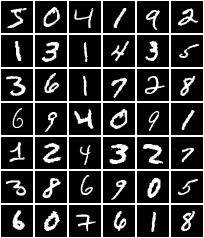

Loaded dataset tensor size:	
 60000
     1
    32
    32
[torch.LongStorage of size 4]



In [2]:
mnist_x = torch.load('train_32x32.t7', 'ascii').data:double()/255
mnist_x = 2*(mnist_x - .5)
print('Max value: '..mnist_x:max())
print('Min value: '..mnist_x:min())
itorch.image(mnist_x[{{1,42},{},{},{}}])
print('Loaded dataset tensor size:')
print(mnist_x:size())
dataSize = mnist_x:size(1)
dimSize = mnist_x:size(2) * mnist_x:size(3) * mnist_x:size(4)

#### Define Generator Network
The Generator Network takes in a random vector of size 100 and outputs 32x32 numbers which are reshaped to produce the image. We use LeakyReLU's which are the way to go for GANs as they fecilitate better gradient flow, however, you can experiment with regular ``nn.Relu`` and see if it matters for our case.

In [3]:
n_hidden = 128
-- Generator
model_g = nn.Sequential()
model_g:add(nn.Linear(100, n_hidden))
model_g:add(nn.LeakyReLU(0.01))
model_g:add(nn.Linear(n_hidden, 32*32))
model_g:add(nn.Tanh())

#### Define Discriminator Network
The Discriminator Network is a binary classifier. It takes in an image of size 32x32 and has two output neurots corresponding to the two classes: Real and Fake. We again LeakyReLUs.

In [4]:
-- Discriminator
model_d = nn.Sequential()
model_d:add(nn.Linear(32*32, n_hidden))
model_d:add(nn.LeakyReLU(0.01))
model_d:add(nn.Linear(n_hidden, 2))

#### Cost function and other hyperparameters
We will use the cross entropy function ``nn.CrossEntropyCriterion()`` to train both the Discriminator and the Generator. The training of the Discriminator is pretty obvious: the network should output Fake when the input is Fake generated image from the Generator, and Real, when it is a real input image from the MNIST dataset.

Training the Generator is slightly less intutive: to train the Generator, we want the Discriminator to output Real when the input from the Generator. We will see how to do this in torch7 in bit.

In [5]:
-- Criterion to train both the Generator and the Discriminator
criterion = nn.CrossEntropyCriterion()
-- Hyperparameters
batchSize = 32
batchSizeHalf = batchSize / 2
batchData = torch.Tensor(batchSize, dimSize)
-- Storage for target
target_d = torch.Tensor(batchSize)
target_g = torch.Tensor(batchSizeHalf)
-- Total batches that can be created from the training set
nBatches = math.floor(dataSize / batchSizeHalf)
-- Optimizer to use when training both the networks. Try using optim.sgd (it doesn't work well!)
optimMethod = optim.adagrad
optimState_g = {learningRate = 0.1}
optimState_d = {learningRate = 0.1}
-- Total no. of epoch we want to train it for
maxEpoch = 20
-- Standard practice: we need to pass these to optim
dParams, dGradParams = model_d:getParameters()
gParams, gGradParams = model_g:getParameters()

#### Helper unctions to get real and fake (generated) data

In [6]:
function get_real_batch(batchData, batchId, shuffle, batchSize)
    for i = 1, batchSize do
        local id = shuffle[ (batchId - 1) * batchSize + i ]
        batchData[i]:copy(mnist_x[{{id},{},{},{}}]:reshape(dimSize))
    end
end

function get_fake_batch(randomData)
    return model_g:forward(randomdata)
end

#### Main training loop
Like any standard torch7 code to train a network, we run a loop from 1 to maxEpoch. In each epoch, we iterate from 1 to the nBatches (computed earlier). 

##### Discriminator 
The input to the Discriminator is ``batchData``, which is of size ``batchSize=32``. The first half (16) are real images and the latter half are fake images. Similarly, the first half of the ``target_d`` is 1 corresponding to real data and the latter half is 2 (fake data). The closure ``fevald`` is standard where we ``forward`` the model and get the output, compute the loss using the ``criterion``, zero out the gradients, backward through the model and return the loss and the gradients computed by the backward.

##### Generator 
The input to the Generator is ``randomOutput``, which is of size ``batchSizeHalf=16`` which produces ``16`` ``randomOutput`` fake images. We pass this through the Detector Network and then compute the loss with the flipped lables (since we now want the Detector to output the label Real for these images). We compute the gradients of the loss and backpropagage. We then pass the gradients of of the loss with respect to the input of the Discriminator network to the Generator Network.

Epoch 1 out of 20 done !!!	


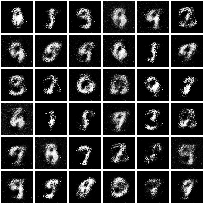

Epoch 2 out of 20 done !!!	


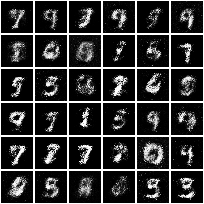

Epoch 3 out of 20 done !!!	


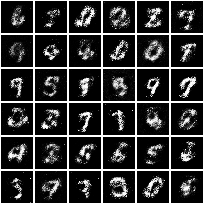

Epoch 4 out of 20 done !!!	


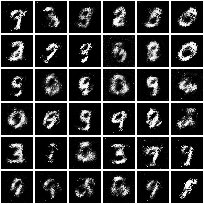

Epoch 5 out of 20 done !!!	


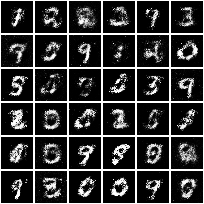

Epoch 6 out of 20 done !!!	


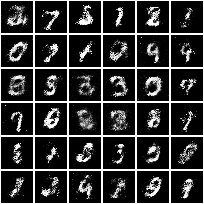

Epoch 7 out of 20 done !!!	


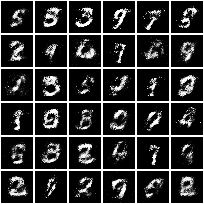

Epoch 8 out of 20 done !!!	


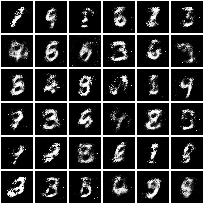

In [ ]:
for epochId = 1, maxEpoch do
    shuffle = torch.randperm(dataSize)

    for t = 1, nBatches do
        get_real_batch(batchData, t, shuffle, batchSizeHalf)

        randomData = torch.rand(batchSizeHalf, 100) - 0.5
        randomOutput = model_g:forward(randomData)
        batchData[{{batchSizeHalf+1, batchSize},{}}]:copy(randomOutput)

        target_d:narrow(1, 1, batchSizeHalf):fill(1)
        target_d:narrow(1, batchSizeHalf+1, batchSizeHalf):fill(2)
        target_g:fill(1)
        
        
        fevald = function(x)
            output_d = model_d:forward(batchData)
            loss_d = criterion:forward(output_d, target_d)
            d_output_d = criterion:backward(output_d, target_d)
            dGradParams:zero()
            model_d:backward(batchData, d_output_d)
            return loss_d, dGradParams / batchSize
        end
        
        fevalg = function(x)
            output_g = model_d:forward(randomOutput)
            loss_g = criterion:forward(output_g, target_g)
            d_output_g = criterion:backward(output_g, target_g)
            d_randomOutput = model_d:backward(randomOutput, d_output_g)
            gGradParams:zero()
            model_g:backward(randomData, d_randomOutput)
            return loss_g, gGradParams / batchSizeHalf
        end

        optimMethod(fevalg, gParams, optimState_g)
        optimMethod(fevald, dParams, optimState_d)
    end
    
    print('Epoch ' .. epochId .. ' out of '..maxEpoch..' done !!!')
    randomData = torch.rand(36, 100) - 0.5
    randImgs = model_g:forward(randomData)
    randImgs = randImgs:reshape(36,1,32,32)
    itorch.image(randImgs)
end